# Task 1




### Highlights:
* We cannot say unequivocally that the average profit in the group in which there was a presentation is lower than in the group in which there was no presentation
* Profit is lower in the group with presentation because it has a lower average expected income
* In fact, the presentation increased profits by an average of 99.18 for each client




### Is the difference between groups in profits statistically significant?
First, let's try to check whether average profit for clients after presentation was lower than average Profit for clients:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel('https://github.com/dmlast/Plata/raw/main/Data%20for%20task%201.xlsx', sheet_name = 'table 2', header = 1)
res = pd.read_excel('https://github.com/dmlast/Plata/raw/main/Data%20for%20task%201.xlsx', sheet_name = 'table 1', header = 1)

In [ ]:
df.head() # check if the data was read correctly

,Client ID,Age,Gender,Monthly Income
0,43,37,M,3905
1,137,37,M,4666
2,257,39,M,4745
3,477,36,M,3815
4,754,31,M,3917


In [ ]:
res.head() # check if the data was read correctly

,Client ID,Profit,Unnamed: 2,Client ID.1,Profit.1
0,137,380,NaN,43.0,634.0
1,1809,333,NaN,257.0,407.0
2,1929,439,NaN,477.0,382.0
3,1976,383,NaN,754.0,331.0
4,2057,147,NaN,825.0,456.0


In [ ]:
# Now let's combine the data into one table and do some preprocessing

no_pres = res[['Client ID', 'Profit']]
pres = res[['Client ID.1', 'Profit.1']].dropna()
pres.columns = ['Client ID', 'Profit']
profits = pd.concat([no_pres, pres], ignore_index=True)
profits


df['Presentation'] = df['Client ID'].apply(lambda x: 1 if x in pres['Client ID'].to_list() else (0 if x in no_pres['Client ID'].to_list() else -1))

df = pd.merge(df, profits, on='Client ID')

df = df.set_index('Client ID')

df = pd.get_dummies(df, drop_first = True, dtype = int)



In [ ]:
df[df['Presentation'] == -1] # check to see if there were any omissions

,Age,Monthly Income,Presentation,Profit,Gender_M
Client ID,,,,,


### T-test and CI

In [ ]:
# There were no omissions
# Let's do a t-test with one-sided alternative hypothesis
profit_presentation_1 = df[df['Presentation'] == 1]['Profit']
profit_presentation_0 = df[df['Presentation'] == 0]['Profit']
t_stat, p_value = stats.ttest_ind(profit_presentation_1, profit_presentation_0, alternative='less')

print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")


T-statistic: -1.3029, P-value: 0.0966


According to the p-value we conclude that **we cannot reject the null hypothesis (of equality of averages) at a significance level of 5%, but we can reject it at a significance level of 10%**. The test results are not interpreted unambiguously, let's make sure of it visually:

In [ ]:
means = df.groupby('Presentation')['Profit'].mean()
stds = df.groupby('Presentation')['Profit'].std()
n = df.groupby('Presentation')['Profit'].count()

confidence_interval = stats.t.ppf(0.975, n - 1) * (stds / np.sqrt(n))
fig = go.Figure()

for presentation_value in df['Presentation'].unique():
    fig.add_trace(go.Box(
        x=df[df['Presentation'] == presentation_value]['Presentation'],
        y=df[df['Presentation'] == presentation_value]['Profit'],
        name=f'Presentation {presentation_value}',
        boxmean=False
    ))

for presentation_value in means.index:
    mean = means[presentation_value]
    ci = confidence_interval[presentation_value]

    fig.add_trace(go.Scatter(
        x=[presentation_value], y=[mean],
        mode='markers',
        marker=dict(color='red', size=10),
        name=f'Mean (Presentation={presentation_value})'
    ))

    fig.add_shape(type='line',
                  x0=presentation_value - 0.2, x1=presentation_value + 0.2,
                  y0=mean - ci, y1=mean - ci,
                  line=dict(color='red', width=2))

    fig.add_shape(type='line',
                  x0=presentation_value - 0.2, x1=presentation_value + 0.2,
                  y0=mean + ci, y1=mean + ci,
                  line=dict(color='red', width=2))

    fig.add_shape(type='line',
                  x0=presentation_value, x1=presentation_value,
                  y0=mean - ci, y1=mean + ci,
                  line=dict(color='red', width=2))


fig.update_xaxes(title='Presentation')
fig.update_yaxes(title='Profit')
fig.update_layout(title='Distribution of Profit by Presentation with Confidence Intervals')
fig.show()

(note to the graph above: this is a boxplot with the mean and confidence intervals plotted on top. to show or hide the boxplot, click Presentation 1 and Presentation 0)

We can see that the confidence intervals overlap quite a bit, which again does not give us a clear interpretation.

However, **temporarily fix the significance level at 10%** and assume that the differences are indeed statistically significant.

Then it can be explained by the fact that the **group that listened to the presentation may be different from the group that did not listen to the presentation**. In other words, selection bias is present:  

* In a laboratory setting, it would be desirable to have within those who agreed to listen to the presentation two randomly selected groups: those who were given the presentation and those who did not. Obviously, this is not realizable in practice.
* Possible reasons for selection bias: people with higher income may value their time more and refuse to listen to the presentation; consent to the presentation may be related to socio-demographic parameters, for example, older people may value their time more and refuse to listen to the presentation.

We can try to test whether selection bias has occurred using logistic regression by estimating the effect of socioeconomic factors on response.


### Logit for selection bias

In [ ]:
X = df[['Age', 'Monthly Income', 'Gender_M']]
y = df['Presentation']

X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.622803
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           Presentation   No. Observations:                  504
Model:                          Logit   Df Residuals:                      500
Method:                           MLE   Df Model:                            3
Date:                Fri, 20 Sep 2024   Pseudo R-squ.:                 0.09778
Time:                        18:00:30   Log-Likelihood:                -313.89
converged:                       True   LL-Null:                       -347.91
Covariance Type:            nonrobust   LLR p-value:                 1.122e-14
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.1576      0.959      3.292      0.001       1.278       5.038
Age              

In [ ]:
pred_probs = result.predict(X)
predictions = (pred_probs >= 0.5).astype(int)
accuracy = np.mean(predictions == y)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.64


Note that the coefficients at gender and age are statistically insignificant and we exclude them:

In [ ]:
X = df[['Monthly Income']]
y = df['Presentation']

X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())
pred_probs = result.predict(X)
predictions = (pred_probs >= 0.5).astype(int)
accuracy = np.mean(predictions == y)
print(f"Accuracy: {accuracy:.2f}")

Optimization terminated successfully.
         Current function value: 0.624240
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           Presentation   No. Observations:                  504
Model:                          Logit   Df Residuals:                      502
Method:                           MLE   Df Model:                            1
Date:                Fri, 20 Sep 2024   Pseudo R-squ.:                 0.09570
Time:                        18:00:36   Log-Likelihood:                -314.62
converged:                       True   LL-Null:                       -347.91
Covariance Type:            nonrobust   LLR p-value:                 3.342e-16
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.4454      0.363      6.742      0.000       1.734       3.156
Monthly Income   

We also test the specification for the logarithm of income, since a nonlinear relationship is possible:

In [ ]:
df['ln_Income'] = df['Monthly Income'].apply(lambda x: np.log(x))
X = df[['ln_Income']]
y = df['Presentation']

X = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())
pred_probs = result.predict(X)
predictions = (pred_probs >= 0.5).astype(int)
accuracy = np.mean(predictions == y)
print(f"Accuracy: {accuracy:.2f}")

Optimization terminated successfully.
         Current function value: 0.624752
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           Presentation   No. Observations:                  504
Model:                          Logit   Df Residuals:                      502
Method:                           MLE   Df Model:                            1
Date:                Fri, 20 Sep 2024   Pseudo R-squ.:                 0.09496
Time:                        18:00:39   Log-Likelihood:                -314.87
converged:                       True   LL-Null:                       -347.91
Covariance Type:            nonrobust   LLR p-value:                 4.342e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.7601      2.953      7.368      0.000      15.972      27.549
ln_Income     -2.5783      0.

Comparing with baseline accuracy:

In [ ]:
class_counts = df['Presentation'].value_counts()
most_freq = class_counts.max()
baseline_accuracy = most_freq / len(df)

print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 0.54


The coefficients are statistically significant, the quality metric is higher than baseline -> we can conclude that **customer income affects the likelihood that customers will use the presentation or not** The model confirms our assumption, customers who use the presentation are different from those who do not. Knowing this, we can further improve this point with a better classifier, but this is not our central concern right now.

### The impact of the presentation: regression with mediation

Under ideal conditions, an A/B test would be needed to test the impact of presentation, as I mentioned above. Under our conditions, we can test the impact using a linear regression with an interaction variable. It would have the following specification:

$Profit_i = \beta_0 + \beta_1 \times Income_i + \beta_2 \times Gender_i + \beta_3 \times Age_i + \beta_4 \times Presentation_i \times Income_i $ $

This modeling is based on the assumption that **the marginal effect of a presentation on each customer is about the same**. This is a strong assumption, for example, richer customers might become more skeptical of the product after the presentation and the presentation would have a negative effect on revenue. Unfortunately, there is no way to test it.

A similar approach would be to estimate the regression on the group that did not receive the presentation and then use the model to predict the value of profits on the subgroup that did receive the presentation, then compare the predicted and actual values, which would give an estimate of the effect of the presentation. However, there is no big difference between this approach and the previous one, they are based on the same assumptions and would give the same estimates.

In [ ]:
df['Income_Presentation'] = df['Monthly Income'] * df['Presentation']
X = df[['Age', 'Monthly Income', 'Gender_M', 'Income_Presentation']]
y = df['Profit']
X = sm.add_constant(X)
model = sm.regression.linear_model.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     127.7
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           5.12e-75
Time:                        16:48:05   Log-Likelihood:                -3349.2
No. Observations:                 504   AIC:                             6708.
Df Residuals:                     499   BIC:                             6729.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -122.7970    

We see statistical insignificance of coefficient estimates at Age and Gender_M. Let us estimate the model without these predictors:

In [ ]:
X = df[['Monthly Income', 'Income_Presentation']]
y = df['Profit']
X = sm.add_constant(X)
model = sm.regression.linear_model.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     255.6
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           3.06e-77
Time:                        16:48:05   Log-Likelihood:                -3349.6
No. Observations:                 504   AIC:                             6705.
Df Residuals:                     501   BIC:                             6718.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -52.4974    

We also test the specification for the logarithm of income, since a nonlinear relationship is possible:

In [ ]:
df['ln_Income_Presentation'] = df['ln_Income'] * df['Presentation']
X = df[['ln_Income', 'ln_Income_Presentation']]
y = df['Profit']
X = sm.add_constant(X)
model = sm.regression.linear_model.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     232.3
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           4.05e-72
Time:                        16:48:05   Log-Likelihood:                -3361.5
No. Observations:                 504   AIC:                             6729.
Df Residuals:                     501   BIC:                             6742.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4775

The model without logarithmization is preferred.

We see that the coefficient estimate on the interaction variable is statistically significant and positive. This means that **presentation did increase revenue per customer**. We can even estimate how much:

In [ ]:
df_pres = df[df['Presentation'] == 1]
df_pres['Profit_0'] = df_pres['Monthly Income'].apply(lambda x: -52.4974 + 0.1126*x)
df_pres['Diff'] = df_pres['Profit'] - df_pres['Profit_0']
print(f"In sum Profit increased {df_pres['Diff'].sum():.2f}, average by {df_pres['Diff'].mean():.2f} for each client")

In sum Profit increased 23109.90, average by 99.18 for each client


# Task 2


### Highlights:

* To answer all the question different specifications (logit, SVM, decision tree, random forest, LGBM) were trained
*   Unfortunately, now it is **hardly but possible to make a positive profit for coming clients**.
*   Decision is saved in updated .xlsx in the end of the code
* I expect **Profit equals \$9.89k** for new clients.





### Optimal metric

First, let us assume that we will be constructing a binary classifier that will predict the client's $p_d$. Now let us think about the interpretation of confusion matrix to build the most accurate qulaity metrics:

* TP. Clients who were TP based on the results of the model generate \$1.5k in revenue for us
* FP. It's an unaccounted risk. If a client has a default and we did not predict it, we incur a loss of -\$5k
* TN. This is an accounted risk: we predicted it and do not bear the loss
* FN. That's lost profit: we turned down solvent customers for nothing.

Accordingly, we maximize the expected profit, which can be expressed as: $$m = 1.5TP - 5 FP$$

Once we have selected the optimal metric, we can proceed directly to solving the classification problem

In [ ]:
from sklearn.metrics import confusion_matrix

def EPr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    m = 1.5 * tp - 5 * fp
    return m

### Data preprocessing

In [ ]:
# Reading
df = pd.read_excel('https://github.com/dmlast/Plata/raw/main/data%20for%20task%202.xlsx', sheet_name = 'dev')
val = pd.read_excel('https://github.com/dmlast/Plata/raw/main/data%20for%20task%202.xlsx', sheet_name = 'valid')
val = val.drop(columns = ['decision'])
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_0
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
2,3,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
3,4,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
4,7,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


In [ ]:
# OHE
df = df.set_index('ID')
val = val.set_index('ID')
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for i in cat_cols:
    df[i] = pd.Categorical(df[i])
    val[i] = pd.Categorical(val[i])
df = pd.get_dummies(df, columns=cat_cols, drop_first = True)
val = pd.get_dummies(val, columns=cat_cols, drop_first = True)
# rather late (after running the basic models) I discovered that 'PAY_2_8', 'PAY_3_1', 'PAY_4_1', 'PAY_4_8', 'PAY_5_6', 'PAY_5_8',
# 'PAY_6_5' just isn't in the valid sample. After some thought, I decided to remove them from df as well:
# the significance estimates for these data are quite low in all models, so they can be neglected
df = df.drop(columns = ['PAY_2_8', 'PAY_3_1', 'PAY_4_1', 'PAY_4_8', 'PAY_5_6', 'PAY_5_8', 'PAY_6_5'])

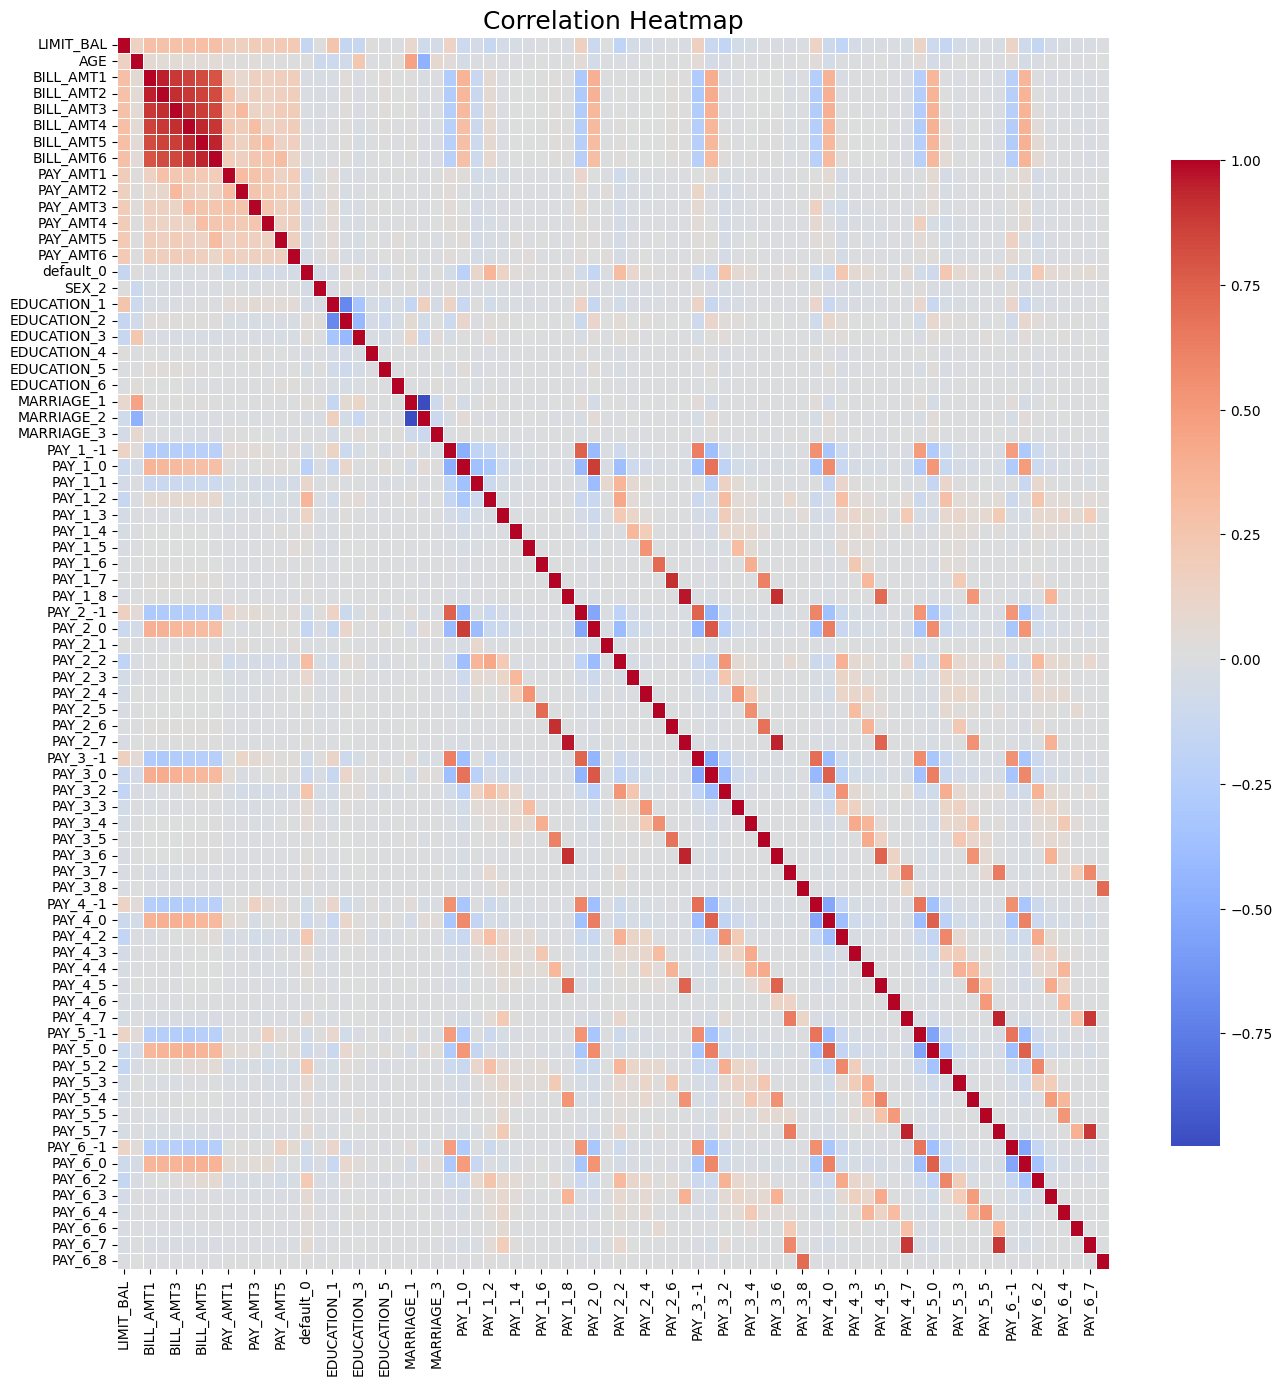

In [ ]:
# Correlation heatmap

corr_matrix = df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix,
            annot=False,
            cmap='coolwarm',
            linewidths=0.5,
            cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap', fontsize=18)
plt.show()

We see that there is no much multicollinearity.

In [ ]:
# Train_test_split

from sklearn.model_selection import train_test_split

X = df.drop(columns=['default_0'])
y = df['default_0']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Training a classifier with a given metric

For this part, I trained several different models with a small gridsearch on the basic hyperparameters

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
import numpy as np
import pandas as pd


precision_scorer = make_scorer(precision_score, greater_is_better=True)

param_grids = {
    'Logistic Regression': (LogisticRegression(max_iter=100, random_state = 42), {
        'C': [0.1, 10]
    }),
    'Decision Tree': (DecisionTreeClassifier(random_state = 0), {
        'max_depth': [10, 100, 1000],
        'min_samples_split': [2, 5, 10]
    }),
    'Random Forest': (RandomForestClassifier(random_state = 0), {
        'n_estimators': [50, 100],
        'max_depth': [10, 100]
    }),
    'SVM': (SVC(probability=True, max_iter=100), {
        'C': [1, 10],
        'kernel': ['linear', 'rbf']
    }),
    'LightGBM': (lgb.LGBMClassifier(random_state=42), {
        'num_leaves': [30, 50],
        'n_estimators': [10, 100]
    })
}

results = []

for name, (model, param_grid) in param_grids.items():
    print(f"Training {name} with params: {param_grid}")
    grid_search = GridSearchCV(model, param_grid, scoring=precision_scorer, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    best_threshold = 0.5
    best_epr = float('-inf')

    for threshold in np.linspace(0, 1, num=101):
        y_pred = (y_pred_proba >= threshold).astype(int)
        epr_score = EPr(y_test, y_pred)

        if epr_score > best_epr:
            best_epr = epr_score
            best_threshold = threshold

    y_pred_optimal = (y_pred_proba >= best_threshold).astype(int)

    precision = precision_score(y_test, y_pred_optimal)

    results.append((name, best_epr, precision, best_params, best_threshold))

results_df = pd.DataFrame(results, columns=['Model', 'Best EPr', 'Precision', 'Best Params', 'Best Threshold'])
print(results_df)

Training Logistic Regression with params: {'C': [0.1, 10]}
Training Decision Tree with params: {'max_depth': [10, 100, 1000], 'min_samples_split': [2, 5, 10]}
Training Random Forest with params: {'n_estimators': [50, 100], 'max_depth': [10, 100]}
Training SVM with params: {'C': [1, 10], 'kernel': ['linear', 'rbf']}
Training LightGBM with params: {'num_leaves': [30, 50], 'n_estimators': [10, 100]}
[LightGBM] [Info] Number of positive: 2398, number of negative: 8418
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3258
[LightGBM] [Info] Number of data points in the train set: 10816, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221709 -> initscore=-1.255737
[LightGBM] [Info] Start training from score -1.255737
[LightGBM] [Info] Number of positive: 2399, 

**Hence, the optimal model is random forest with parameters {'max_depth': 10, 'n_estimators': 50} and threshold = 0.74**

Now we can predict probas for validation data:

In [ ]:
model = RandomForestClassifier(max_depth = 10, n_estimators= 50, random_state = 0)
model.fit(X_train, y_train)
predicted_probas = model.predict_proba(val)[:, 1]
val['probas'] = predicted_probas
val['decision'] = val['probas'].apply(lambda x: 1 if x >= 0.74 else 0)

In [ ]:
expected_tp = np.sum(val[val['decision'] == 1]['probas'])
expected_fp = np.sum(val['decision']) - expected_tp
expected_epr = 1.5 * expected_tp - 5 * expected_fp

print(f"Expected EPr: {expected_epr}")

Expected EPr: 9.888239525293827


Now we can save the results:

In [ ]:
val.to_excel('valid.xlsx')